In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [171]:
# define crucial functions to extract the qr code from the image


def get_start_and_end_points(img: np.ndarray) -> tuple:
    # define all starting points as -1 (not found yet)
    start_row = -1
    start_col = -1
    end_row = -1
    end_col = -1

    # loop through the image to find the start and end points of the qr code
    # what happens here is that, initially, the value of the pixel is 255 (white)
    # so we keep looping until we find a pixel that is not white, and thus, we found the start point
    # we do the same for the end point, but we loop from the end of the image to the start
    # to find the end point. The same goes for the columns using the transpose of the image
    # to loop through the columns

    # loop through each row of pixels
    for row_index, row in enumerate(img):
        # for each pixel in that row
        for pixel in row:
            # if there is a pixel that is not white
            if pixel != 255:
                # then we found the start row!
                start_row = row_index

                # break the loop
                break

        # if after the loop, the start row is still -1, then no non-white pixels were found, and thus we continue to the next row
        # otherwise, the next line checks if the start row was found, and if it was, it breaks the outer loop
        if start_row != -1:
            break

    # do the same for the end row, but loop through that row in reverse
    for row_index, row in enumerate(img[::-1]):
        for pixel in row:
            if pixel != 255:
                end_row = img.shape[0] - row_index
                break
        if end_row != -1:
            break

    # do the same for the columns, but using the transpose of the image
    for col_index, col in enumerate(cv2.transpose(img)):
        for pixel in col:
            if pixel != 255:
                start_col = col_index
                break
        if start_col != -1:
            break

    # do the same for the end column, but using the transpose of the image and looping in reverse
    for col_index, col in enumerate(cv2.transpose(img)[::-1]):
        for pixel in col:
            if pixel != 255:
                end_col = img.shape[1] - col_index
                break
        if end_col != -1:
            break

    # return the start and end points
    return start_row, start_col, end_row, end_col


def apply_kernel(img, kernel):
    # Apply filter
    filtered = cv2.filter2D(img, -1, kernel)

    # Convert the result back to uint8
    back_to_int = np.uint8(np.absolute(filtered))

    # Add the Laplacian result to the original image to sharpen it
    return cv2.add(img, back_to_int)


def get_grid_cell_size_and_num(qr_no_quiet_zone: np.ndarray) -> tuple:
    # get the size of the first non-white pixel in the qr code
    size = 0
    for pixel in qr_no_quiet_zone[0]:
        if pixel != 0:
            break
        size += 1

    # The size of the grid cell is the size of the qr code divided by 7, which is the width of the top-left border of the alignment pattern
    grid_cell_size = round(size / 7)

    # The number of grid cells is the size of the qr code divided by the size of the grid cell
    grid_cells_num = round(qr_no_quiet_zone.shape[0] / grid_cell_size)

    # return the size of the grid cell and the number of grid cells
    return grid_cell_size, grid_cells_num


def get_numeric_qr_cells(img: np.ndarray) -> np.ndarray:
    # get the start and end idxs of the qr code
    start_row, start_col, end_row, end_col = get_start_and_end_points(img)

    # get the qr code without the quiet zone
    qr_no_quiet_zone = img[start_row:end_row, start_col:end_col]

    # get the size of a grid cell and the number of grid cells
    grid_cell_size, grid_cells_num = get_grid_cell_size_and_num(qr_no_quiet_zone)

    # reshape the qr code to a 2D array of grid cells
    qr_cells = qr_no_quiet_zone.reshape(
        (
            grid_cells_num,
            grid_cell_size,
            grid_cells_num,
            grid_cell_size,
        )
    ).swapaxes(1, 2)

    # form an empty array to store the numeric values of the qr cells
    qr_cells_numeric = np.ndarray((grid_cells_num, grid_cells_num), dtype=np.uint8)

    # loop through the qr cells and get the median value of each cell
    for i, row in enumerate(qr_cells):
        for j, cell in enumerate(row):
            qr_cells_numeric[i, j] = np.median(cell) // 255

    # return the numeric qr cells
    return qr_cells_numeric

In [3]:
img = cv2.imread("test_data/11_wewowewo.png", cv2.IMREAD_GRAYSCALE)

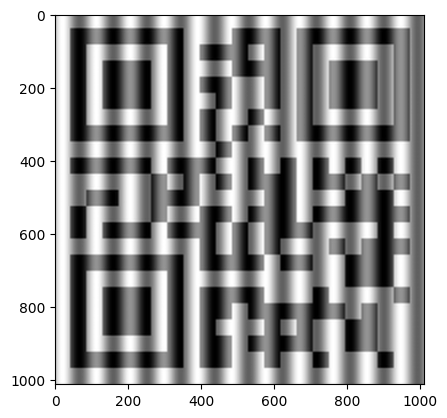

In [5]:
plt.imshow(img, cmap="gray")

In [10]:
def give_me_circle_mask_nowww(mask_size, radius):
    mask = np.zeros(mask_size)
    cy = mask.shape[0] // 2
    cx = mask.shape[1] // 2
    return cv2.circle(mask, (cx, cy), radius, (255, 255, 255), -1).astype(np.uint8)


def try_lowpass(dft_img, limit, gaussian: bool = False):
    mask = give_me_circle_mask_nowww(dft_img.shape, limit)
    if gaussian:
        mask = cv2.GaussianBlur(mask, (21, 21), 0)
    dft_img_shifted = np.fft.fftshift(dft_img)
    dft_img_shifted_lowpass = np.multiply(dft_img_shifted, mask)
    plot_shifted_fft_and_ifft(dft_img_shifted_lowpass)


def try_highpass(dft_img, limit, gaussian: bool = False, keep_dc: bool = False):
    mask = ~give_me_circle_mask_nowww(dft_img.shape, limit)
    if gaussian:
        mask = cv2.GaussianBlur(mask, (21, 21), 0)
    if keep_dc:
        mask[dft_img.shape[0] // 2, dft_img.shape[1] // 2] = 255
    dft_img_shifted = np.fft.fftshift(dft_img)
    dft_img_shifted_highpass = np.multiply(dft_img_shifted, mask)
    plot_shifted_fft_and_ifft(dft_img_shifted_highpass)

    return dft_img_shifted_highpass


def plot_shifted_fft_and_ifft(dft_img_shifted):
    img = np.fft.ifft2(np.fft.ifftshift(dft_img_shifted))
    fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), nrows=1, ncols=2)
    ax1.set(
        yticks=[0, img.shape[0] // 2, img.shape[0] - 1],
        yticklabels=[-img.shape[0] // 2, 0, img.shape[0] // 2 - 1],
    )
    ax1.set(
        xticks=[0, img.shape[1] // 2, img.shape[1] - 1],
        xticklabels=[-img.shape[1] // 2, 0, img.shape[1] // 2 - 1],
    )
    ax1.imshow(np.abs(dft_img_shifted) ** 0.1, cmap="gray")
    ax2.imshow(np.abs(img), cmap="gray")

In [168]:
def give_me_circle_mask_nowww(mask_size, radius):
    mask = np.zeros(mask_size)
    cy = mask.shape[0] // 2
    cx = mask.shape[1] // 2
    return cv2.circle(mask, (cx, cy), radius, (255, 255, 255), -1).astype(np.uint8)


def try_band_remove(
    dft_img,
    mask,
    gaussian: bool = False,
    keep_dc: bool = False,
    plot: bool = True,
    return_dft: bool = False,
):
    if gaussian:
        mask = cv2.GaussianBlur(mask, (21, 21), 0)
    if keep_dc:
        mask[dft_img.shape[0] // 2, dft_img.shape[1] // 2] = 255
    dft_img_shifted = np.fft.fftshift(dft_img)
    dft_img_shifted_band_removed = np.multiply(dft_img_shifted, mask)

    if plot:
        plot_shifted_fft_and_ifft(dft_img_shifted_band_removed)

    img = np.fft.ifft2(np.fft.ifftshift(dft_img_shifted_band_removed))

    if return_dft:
        return dft_img_shifted_band_removed, img

    return img


def get_rectangle_mask(mask_size, x1, y1, x2, y2):
    mask = np.zeros(mask_size)
    return cv2.rectangle(mask, (x1, y1), (x2, y2), (255, 255, 255), -1).astype(np.uint8)

In [153]:
dft_img = np.fft.fft2(img)

low_freq = 50
high_freq = 100

# mask_large = give_me_circle_mask_nowww(dft_img.shape, high_freq)
# mask_small = ~give_me_circle_mask_nowww(dft_img.shape, low_freq)

# mask = ~ (mask_large & mask_small)

center = (dft_img.shape[0] // 2, dft_img.shape[1] // 2)

w_large = 50
h_large = 4
w_small = 30
h_small = 4
mask1 = get_rectangle_mask(
    dft_img.shape,
    center[1] - w_large // 2,
    center[0] - h_large // 2,
    center[1] + w_large // 2,
    center[0] + h_large // 2,
)
mask2 = ~get_rectangle_mask(
    dft_img.shape,
    center[1] - w_small // 2,
    center[0] - h_small // 2,
    center[1] + w_small // 2,
    center[0] + h_small // 2,
)
mask = ~(mask1 & mask2)


def get_exclude_freq_mask(center, x_region, y_region):
    large_mask = get_rectangle_mask(
        dft_img.shape,
        center[1] - x_region[1] // 2,
        center[0] - y_region[1] // 2,
        center[1] + x_region[1] // 2,
        center[0] + y_region[1] // 2,
    )
    small_mask = ~get_rectangle_mask(
        dft_img.shape,
        center[1] - x_region[0] // 2,
        center[0] - y_region[0] // 2,
        center[1] + x_region[0] // 2,
        center[0] + y_region[0] // 2,
    )
    return ~(large_mask & small_mask)

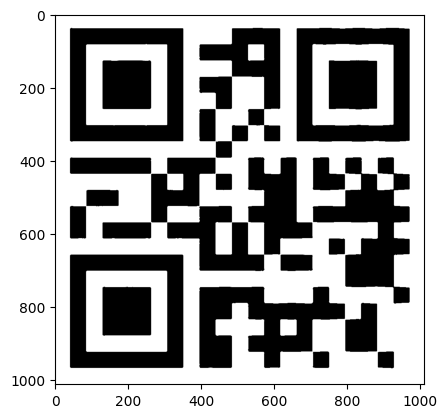

In [191]:
k = 21
mask = get_exclude_freq_mask(center, (k, k + 1), (-1, 1))

dft_img, img = try_band_remove(
    dft_img, mask, gaussian=False, keep_dc=True, plot=False, return_dft=True
)

# apply thresholding on x
x = np.abs(img)

x = cv2.normalize(x, None, 0, 255, cv2.NORM_MINMAX)

x = cv2.threshold(x, 127, 255, cv2.THRESH_BINARY)[1]

plt.imshow(x, cmap="gray")

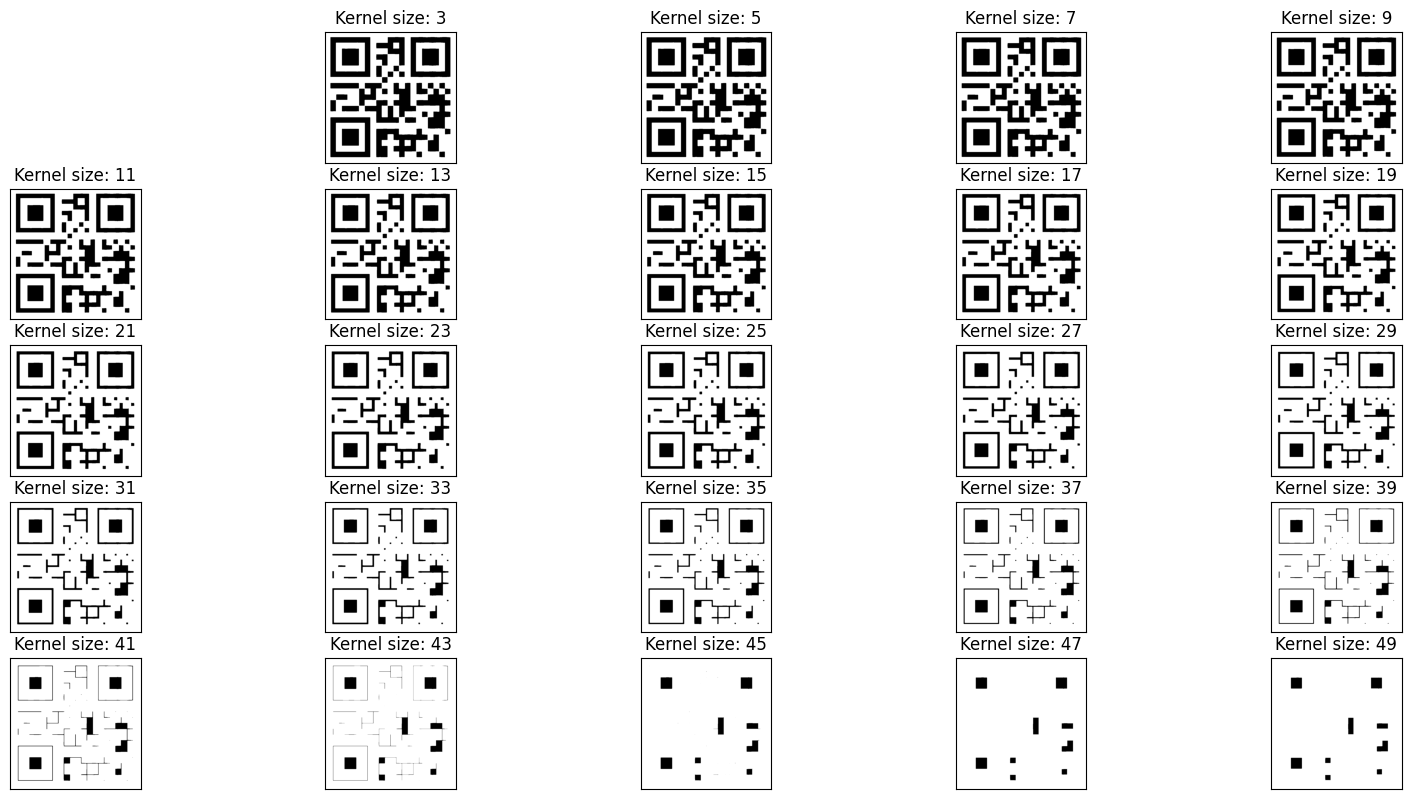

In [195]:
# perform dilation on x with multiple kernel sizes and plot them all
fig = plt.figure(figsize=(20, 20))
for i in range(3, 50, 1):
    if i % 2 == 0 or i == 1:
        continue

    kernel = np.ones((i, i), np.uint8)

    dilation = cv2.dilate(x, kernel, iterations=1)

    fig.add_subplot(10, 10, i)

    plt.title(f"Kernel size: {i}")

    # remove ticks
    plt.xticks([])
    plt.yticks([])

    plt.imshow(dilation, cmap="gray")

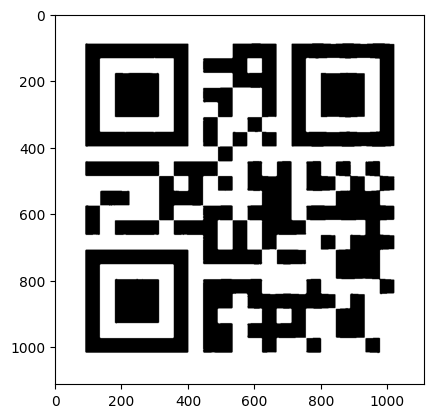

In [218]:
plt.imshow(img, cmap="gray")

In [223]:
image.shape

(1012, 1012)

error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:94: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<1, -1, -1>, cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<1, -1, -1>, VDcn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Unsupported depth of input image:
>     'VDepth::contains(depth)'
> where
>     'depth' is 6 (CV_64F)


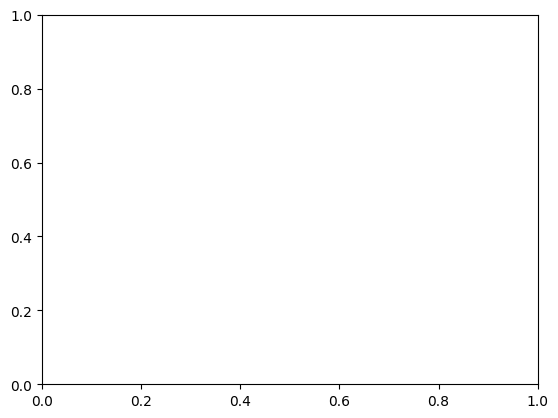

In [230]:
image = x

if len(image.shape) == 2:
    # If it has only one channel, it's already grayscale
    gray = image
else:
    # Convert the input image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold the image
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# thresh to uint8
thresh = np.uint8(thresh)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the image
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# Iterate through contours and find centers
for contour in contours:
    # Calculate the moments of the contour
    M = cv2.moments(contour)
    # Calculate the centroid of the contour
    if M["m00"] != 0:
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        # Print the centroid coordinates
        print("Center coordinates:", cX, cY)
    else:
        cX, cY = 0, 0  # If the moment is zero, consider center at origin

    # Optionally, draw the contours and centers
    cv2.drawContours(image, [contour], -1, (0, 255, 0), 2)
    cv2.circle(image, (cX, cY), 5, (0, 0, 255), -1)

# Show the image with contours and centers
ax.axis("off")  # Turn off axis
plt.show()

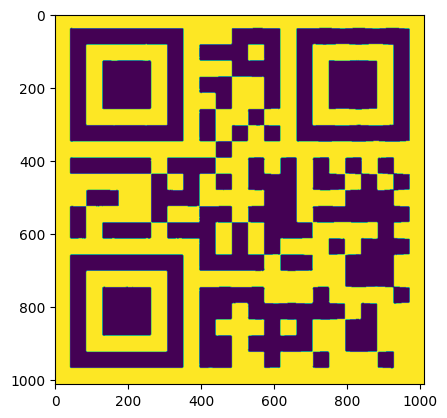

In [231]:
plt.imshow(thresh)